In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
from keras.preprocessing import image
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 
from tqdm import tqdm
import shutil
import time
from PIL import Image

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [12]:
dataset = './dataset/images/'
imageLabels = './dataset/imageLabels.txt'

In [13]:
# Dataset settings
train_vol = 0.8

# Train settings
batch_size = 128
epochs = 50
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically

In [14]:
categories = [
    "Pepperoni",
    "Bacon",
    "Mushrooms",
    "Onions",
    "Peppers",
    "Black olives",
    "Tomatoes",
    "Spinach",
    "Fresh basil",
    "Arugula",
    "Broccoli",
    "Corn",
    "Pineapple"
]

In [15]:
with open(imageLabels, 'r') as file:
    lines = file.readlines()
    labels = []
    index=1
    imgs =[]
    for line in lines:
        class_array = [int(num) for num in line.split()]
        if np.array_equal(class_array, np.zeros(13, dtype=int)) == False:
               labels.append(class_array)
               imgs.append(index)
     
        index+=1    
     
    y1=labels
    labels= np.array(labels)    
        

print(labels)
print(imgs[0])


FileNotFoundError: [Errno 2] No such file or directory: './dataset/imageLabels.txt'

In [110]:
print(labels[0])

[0 0 0 1 1 0 0 0 0 0 0 0 0]


In [111]:
image_names = ['{:05d}'.format(i) for i in imgs]
image_names[0:10]

['00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00010',
 '00011']

In [112]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)  # Adjust channels as needed
    img = tf.image.resize(img, [244, 244])  # Set desired image dimensions
    img = img / 255.0  # Normalize pixel values
    return img

In [113]:
image_paths = [os.path.join(dataset, img+'.jpg') for img in image_names]
image_paths[0:10]

['./dataset/images/00001.jpg',
 './dataset/images/00002.jpg',
 './dataset/images/00003.jpg',
 './dataset/images/00004.jpg',
 './dataset/images/00005.jpg',
 './dataset/images/00006.jpg',
 './dataset/images/00007.jpg',
 './dataset/images/00008.jpg',
 './dataset/images/00010.jpg',
 './dataset/images/00011.jpg']

In [114]:
print(len(image_paths), len(labels))

6446 6446


In [115]:
def parse_function(filename, label):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [116]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
# Parse and preprocess observations in parallel
dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

In [117]:
len(dataset)

6446

In [118]:
int(train_vol * len(dataset))

5156

In [119]:
batch_size

128

In [120]:
dataset = dataset.shuffle(buffer_size=9213)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

        
# Split into train/validate
train_size = int(train_vol * len(dataset))

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [121]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 13), dtype=tf.int32, name=None))>

In [122]:
for image, label in dataset.take(1):
    input_tensor = tf.keras.Input(shape=image.shape)

In [123]:
print(image.shape)

(224, 224, 3)


In [206]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 16)      1216      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 53, 53, 32)       0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 53, 53, 32)       

In [207]:
model.compile(
    optimizer='adam',
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=['accuracy'])

In [208]:
"""
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)
"""
# Train model
run_hist = model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size)

Epoch 1/50
41/41 [==============================] - 42s 745ms/step - loss: 0.5273 - accuracy: 0.1228 - val_loss: 0.5032 - val_accuracy: 0.3248
Epoch 2/50
41/41 [==============================] - 33s 679ms/step - loss: 0.3941 - accuracy: 0.1732 - val_loss: 0.3935 - val_accuracy: 0.3008
Epoch 3/50
41/41 [==============================] - 34s 686ms/step - loss: 0.3642 - accuracy: 0.2002 - val_loss: 0.3455 - val_accuracy: 0.3217
Epoch 4/50
41/41 [==============================] - 33s 678ms/step - loss: 0.3490 - accuracy: 0.2380 - val_loss: 0.3335 - val_accuracy: 0.3194
Epoch 5/50
41/41 [==============================] - 34s 680ms/step - loss: 0.3417 - accuracy: 0.2475 - val_loss: 0.3258 - val_accuracy: 0.3101
Epoch 6/50
41/41 [==============================] - 34s 676ms/step - loss: 0.3316 - accuracy: 0.2806 - val_loss: 0.3094 - val_accuracy: 0.3271
Epoch 7/50
41/41 [==============================] - 33s 672ms/step - loss: 0.3293 - accuracy: 0.2752 - val_loss: 0.3140 - val_accuracy: 0.2434

In [209]:
def learning_curves(history): 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), accuracy, label='Training accuracy')
    plt.plot(range(1, epochs+1), val_accuracy, label='Validation accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, accuracy, val_accuracy

In [186]:
import matplotlib.style as style 

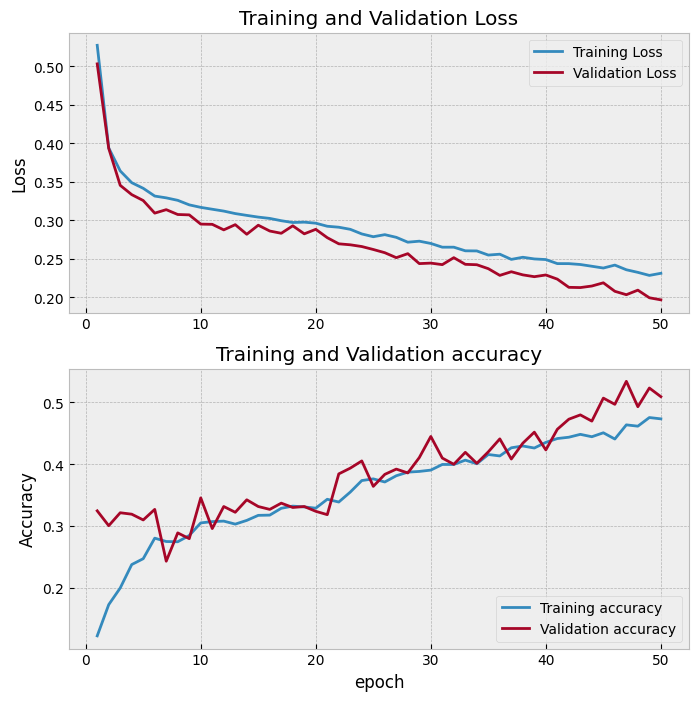

In [210]:
loss, val_loss, accuracy, val_accuracy = learning_curves(run_hist)


In [214]:
from datetime import datetime


In [217]:
# Get the current date and time
t = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the export path
export_path = "./save/{}".format(t)

# Export the model
tf.saved_model.save(model, export_path)

print("Model CNN was exported in this path: '{}'".format(export_path))

INFO:tensorflow:Assets written to: ./save/20240302_211436\assets


INFO:tensorflow:Assets written to: ./save/20240302_211436\assets


Model CNN was exported in this path: './save/20240302_211436'


In [49]:
# Load the saved model
export_path='./save/20240302_211436'

loaded_model = tf.saved_model.load(export_path)

# Transfer Learning : ResNet50

In [9]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3),
)

#num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(13, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 24,115,597 (91.99 MB)

 Trainable params: 527,885 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# Compile settings
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
loss = tf.keras.metrics.binary_crossentropy

In [11]:
# Compile model
model.compile(optimizer= optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)

# Train model
run_hist = model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[checkpoint, tensorboard_callback])

In [ ]:
loss, val_loss, accuracy, val_accuracy = learning_curves(run_hist)
